Natural lands analysis
===

This notebooks uses the Model My Watershed API to retrieve forested, natural, and total area for each cluster, focus area, FieldDoc geometry, WeConservePA geometry, and HUC12 geometry in the 0204 HUC4

## Setup

In [1]:
# Import packages
from pathlib import Path
import pandas as pd
import geopandas as gpd
import json
from modelmw_client import *
from IPython.display import clear_output
import csv
from shapely.validation import make_valid
from shapely.geometry import shape, MultiPolygon, LineString, MultiLineString

# Plotting packages
import matplotlib.pyplot as plt

## File paths

In [2]:
# Find your current working directory, which should be folder for this notebook.
Path.cwd()

WindowsPath('C:/Users/clulay/OneDrive - LimnoTech/Documents/GitHub/pollution-assessment/stage2')

In [7]:
# Set your project directory to your local folder for your clone of this repository
project_path = Path.cwd().parent
project_path

WindowsPath('C:/Users/clulay/OneDrive - LimnoTech/Documents/GitHub/pollution-assessment')

In [8]:
# Path to WeConservePA protected lands parquet file that excludes DRWI geoms
wcpa_path = project_path / Path('stage2/Protected_Lands/WCPA_exclude_DRWI.parquet')
wcpa_path.exists()

True

## Private file paths
- Download from https://drive.google.com/drive/folders/1HKlnA3lC2xvKBQ1bg1J08gsEB3N9rp2V
- Save in `stage2/private` folder

In [9]:
# Path to FieldDoc protected lands export file
fielddoc_path = project_path / Path('stage2/private/protection_bmps_from_FieldDoc.parquet')
fielddoc_path.exists()

True

# Load data

## Protected Lands from WeConservePA

In [10]:
# Import weconservePA protected lands
wcpa_gdf = gpd.read_parquet(wcpa_path)

In [11]:
# Add data source tag
wcpa_gdf['data_source'] = 'weconservePA_2022'

## Protected Lands from FieldDoc

In [12]:
# Import FieldDoc protected lands 
fielddoc_gdf = gpd.read_parquet(fielddoc_path)

# Add a column to fielddoc_gdf with data source
fielddoc_gdf['data_source'] = 'fielddoc_2022-08-11'

## DRWI Geographies

In [13]:
# Import cluster and focus area geometries
cluster_gdf = gpd.read_parquet(project_path / Path('stage1/data/cluster_df.parquet'))  
focusarea_gdf = gpd.read_parquet(project_path / Path('stage1/data/fa_phase2_df.parquet'))

focusarea_gdf.cluster = focusarea_gdf.cluster.replace('Kirkwood Cohansey Aquifer', 'Kirkwood - Cohansey Aquifer') # update name for consistency with other files 
focusarea_gdf.set_index('name', inplace=True)

## HUC12s

In [14]:
huc12_gdf = gpd.read_parquet(project_path / Path('stage2/data_output/huc12_0204.parquet'))

In [15]:
huc12_gdf.rename(columns={'huc12': 'name'}, inplace=True)
huc12_gdf.set_index('name', inplace=True)

# Transform projections
All data needs to be in lat/long projection to be understood by MMW.

In [16]:
# Latest fielddoc export has no attached projection
# Set fielddoc projection to the original fielddoc export projection 
fielddoc_gdf = fielddoc_gdf.set_crs(epsg=4326, inplace=True, allow_override=True)

In [17]:
wcpa_gdf.to_crs(epsg=4326, inplace=True)
cluster_gdf.to_crs(epsg=4326, inplace=True)
focusarea_gdf.to_crs(epsg=4326, inplace=True)
huc12_gdf.to_crs(epsg=4326, inplace=True)

# Validate geometries and explode those that are not a singular closed loop

## Focus areas

In [18]:
muddyrun_gdf = focusarea_gdf[focusarea_gdf.index=='Muddy Run']
explode_fa_gdf = muddyrun_gdf.explode()
explode_fa_gdf

C:\Users\clulay\AppData\Local\Temp\ipykernel_2368\4109479401.py:2: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  explode_fa_gdf = muddyrun_gdf.explode()


cluster strategy   nord    phase change  \
name                                                                       
Muddy Run 0  Kirkwood - Cohansey Aquifer   hybrid  15092  Phase 2   None   
          1  Kirkwood - Cohansey Aquifer   hybrid  15092  Phase 2   None   

             tier subfocusare  area_acres name_final  \
name                                                   
Muddy Run 0  None        None   8887.9498  Muddy Run   
          1  None        None   8887.9498  Muddy Run   

                                                     geom_buff  \
name                                                             
Muddy Run 0  01060000206A7F00000200000001030000000100000094...   
          1  01060000206A7F00000200000001030000000100000094...   

                                                          geom  
name                                                            
Muddy Run 0  POLYGON ((-75.13781 39.55753, -75.13732 39.555...  
          1  POLYGON ((-75.18030 39.58255, -75.18030 39.582...

<AxesSubplot:>

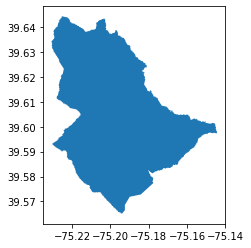

In [19]:
x = explode_fa_gdf[1:2]
x
x.plot()

In [20]:
# Muddy Run 
#explode_fa_gdf_valid = explode_fa_gdf[explode_fa_gdf['geom'].type != 'LineString']
#explode_fa_gdf_valid
#MR_gdf = explode_fa_gdf_valid.explode()

In [21]:
explode_fa_gdf.to_file(project_path / Path('stage2/Protected_Lands/muddyrun.geojson'), driver="GeoJSON")
MR_json = json.load(open(project_path / Path('stage2/Protected_Lands/muddyrun.geojson')))

## WCPA

In [22]:
wcpa_gdf_invalid = wcpa_gdf[wcpa_gdf.is_valid == False]
invalid_ind = wcpa_gdf_invalid.index.to_list()
wcpa_gdf_invalid

,OBJECTID,Category,sitename,esmthldr,eholdtype,own_name,own_type,URL,purpose,year_est,...,County,Municipali,Muni_Type,Muni,MMW,Shape_Leng,Shape_Area,RECLASS2,geometry,data_source
12101,12106,Local,New Kingston Mountain,NaN,NaN,"New York, City",Local - Municipal,https://www1.nyc.gov,Recreational,0,...,"Delaware, Delaware","Middletown, Roxbury","Township, Township",Roxbury,Park or Recreational Area,14717.967316,1.843782e+06,Park or Recreation Area - Local,"MULTIPOLYGON (((-74.64573 42.23793, -74.65301 ...",weconservePA_2022


In [23]:
for i in invalid_ind:
    geom = wcpa_gdf.loc[i]['geometry']
    valid = make_valid(geom)
    wcpa_gdf.at[i,'geometry'] = valid

# Save geometries to geojsons

In [24]:
# JSON cannot interpret categorical datatype. Convert all categorical to object
cluster_gdf = cluster_gdf.reset_index()
cluster_gdf = cluster_gdf.astype({'name': object, 'labels': object})

In [25]:
wcpa_dtypes = {
    'Category': 'object',
    'sitename': 'object',
    'esmthldr': 'object',
    'eholdtype': 'object',
    'own_name': 'object',
    'own_type': 'object',
    'purpose': 'object',
    'pubaccess': 'object',
    'Landscape': 'object',
    'Cluster': 'object',
    'LTSA': 'object',
    'WTRSA': 'object',
    'State_abb': 'object',
    'State': 'object',
    'County': 'object',
    'Municipali': 'object',
    'Muni_Type': 'object',
    'Muni': 'object',
    'MMW': 'object',
    'RECLASS2': 'object'
}

wcpa_gdf = wcpa_gdf.astype(wcpa_dtypes)

In [26]:
# Subset wcpa into 5 separate files bc api capacity is 5000 calls/day
wcpa_1 = wcpa_gdf[0:4999]
wcpa_2 = wcpa_gdf[4999:9999]
wcpa_3 = wcpa_gdf[9999:14999]
wcpa_4 = wcpa_gdf[14999:19999]
wcpa_5 = wcpa_gdf[19999:22138]

In [27]:
wcpa_1.to_file(project_path / Path('stage2/Protected_Lands/wcpa1.geojson'), driver="GeoJSON")
wcpa1_json = json.load(open(project_path / Path('stage2/Protected_Lands/wcpa1.geojson')))

wcpa_2.to_file(project_path / Path('stage2/Protected_Lands/wcpa2.geojson'), driver="GeoJSON")
wcpa2_json = json.load(open(project_path / Path('stage2/Protected_Lands/wcpa2.geojson')))

wcpa_3.to_file(project_path / Path('stage2/Protected_Lands/wcpa3.geojson'), driver="GeoJSON")
wcpa3_json = json.load(open(project_path / Path('stage2/Protected_Lands/wcpa3.geojson')))

wcpa_4.to_file(project_path / Path('stage2/Protected_Lands/wcpa4.geojson'), driver="GeoJSON")
wcpa4_json = json.load(open(project_path / Path('stage2/Protected_Lands/wcpa4.geojson')))

wcpa_5.to_file(project_path / Path('stage2/Protected_Lands/wcpa5.geojson'), driver="GeoJSON")
wcpa5_json = json.load(open(project_path / Path('stage2/Protected_Lands/wcpa5.geojson')))

C:\Users\clulay\.conda\envs\WikiSRAT\lib\site-packages\geopandas\io\file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
C:\Users\clulay\.conda\envs\WikiSRAT\lib\site-packages\geopandas\io\file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
C:\Users\clulay\.conda\envs\WikiSRAT\lib\site-packages\geopandas\io\file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
C:\Users\clulay\.conda\envs\WikiSRAT\lib\site-packages\geopandas\io\file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Ind

In [28]:
fielddoc_gdf.to_file(project_path / Path('stage2/private/fielddoc.geojson'), driver="GeoJSON")
fd_json = json.load(open(project_path / Path('stage2/private/fielddoc.geojson')))

cluster_gdf.to_file(project_path / Path('stage2/Protected_Lands/cluster.geojson'), driver="GeoJSON")
cluster_json = json.load(open(project_path / Path('stage2/Protected_Lands/cluster.geojson')))

focusarea_gdf.to_file(project_path / Path('stage2/Protected_Lands/focusarea.geojson'), driver="GeoJSON")
focusarea_json = json.load(open(project_path / Path('stage2/Protected_Lands/focusarea.geojson')))

huc12_gdf.to_file(project_path / Path('stage2/Protected_Lands/huc12.geojson'), driver="GeoJSON")
huc12_json = json.load(open(project_path / Path('stage2/Protected_Lands/huc12.geojson')))

C:\Users\clulay\.conda\envs\WikiSRAT\lib\site-packages\geopandas\io\file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
C:\Users\clulay\.conda\envs\WikiSRAT\lib\site-packages\geopandas\io\file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


# Analyze land use in MMW

In [29]:
staging_api_key = '92e98c45471a525608b98885f43468d68d471dca'

In [30]:
# Create an API user
mmw_run = ModelMyWatershedAPI(api_key=staging_api_key, use_staging=True)

## Get natural land function

In [31]:
def get_3030(geojson):
    fa_3030_dict = {'name':[],
                    'mmw_area_m2': [],
                    'forest_area_m2': [],
                    'natural_area_m2': [],
                    'perc_forest': [],
                    'perc_natural': [],
                    'area_ac': []}
    

    forest_lu = [41, 42, 43]

    # Include open water, forest, shrub/scrub, grassland/herbaceous, and wetlands as "natural"
    natural_lu = [11, 41, 42, 43, 52, 71, 90, 95]
    
    for item in geojson['features']:
        if 'practice_id' in geojson['features'][0]['properties']:
            name = item['properties']['practice_id']
            area = "NaN"
            
        if 'OBJECTID' in geojson['features'][0]['properties']:
            name = item['properties']['OBJECTID']
            area = item['properties']['Area_Ac']                                 
        
        if 'area_acres' in geojson['features'][0]['properties']:
            name = item['properties']['name']
            area = item['properties']['area_acres']
            
        if 'acres' in geojson['features'][0]['properties']:
            name = item['properties']['name']
            area = item['properties']['acres']
            
        else:
            #name = item['properties']['name']
            #area = 'NaN'
            name = item['properties']['OBJECTID']
            area = item['properties']['Area_Ac']                                 
        
        
        try:
            item_lu = mmw_run.run_mmw_job(
                mmw_run.land_endpoint.format("2019_2019"),
                name,
                item['geometry'])

            item_lu_df = pd.DataFrame().from_dict(item_lu['result_response']['result']['survey']['categories'])
            
            total_area_m2 = item_lu_df['area'].sum()

            forest_df = item_lu_df[item_lu_df['nlcd'].isin(forest_lu)]
            forest_m2 = forest_df['area'].sum()

            natural_df = item_lu_df[item_lu_df['nlcd'].isin(natural_lu)]
            natural_m2 = natural_df['area'].sum()

            perc_forest = forest_m2/total_area_m2 * 100
            perc_natural = natural_m2/total_area_m2 * 100

            fa_3030_dict['name'].append(name)
            fa_3030_dict['mmw_area_m2'].append(total_area_m2)
            fa_3030_dict['forest_area_m2'].append(forest_m2)
            fa_3030_dict['natural_area_m2'].append(natural_m2)
            fa_3030_dict['area_ac'].append(area)
            fa_3030_dict['perc_forest'].append(perc_forest)
            fa_3030_dict['perc_natural'].append(perc_natural)

            print(f'Finished: {name}')
            
        except KeyError:
            print(f'***SKIPPED: {name}***')
    
    if name != 'Muddy Run':
        fa_3030_df = pd.DataFrame().from_dict(fa_3030_dict)
        return(fa_3030_df)
    
    else:
        fa_3030_df = pd.DataFrame().from_dict(fa_3030_dict)

        total_area_m2 = fa_3030_df['mmw_area_m2'].sum()
        natural_m2 = fa_3030_df['natural_area_m2'].sum()
        forest_m2 = fa_3030_df['forest_area_m2'].sum()
        
        perc_forest = forest_m2/total_area_m2 * 100
        perc_natural = natural_m2/total_area_m2 * 100
        
        df = pd.DataFrame({'name': ['Muddy Run'],
                           'mmw_area_m2': [total_area_m2],
                           'forest_area_m2': [forest_m2],
                           'natural_area_m2': [natural_m2],
                           'area_ac': [area],
                           'perc_forest': [perc_forest],
                           'perc_natural': [perc_natural]})
                           
        return(df)

In [32]:
wcpa2_lu_df = get_3030(wcpa2_json)

Finished: 5000
Finished: 5001
Finished: 5002
Finished: 5003
Finished: 5004
Finished: 5005
Finished: 5006
Finished: 5007
Finished: 5008
Finished: 5009
Finished: 5010
Finished: 5011
Finished: 5012
Finished: 5013
Finished: 5014
Finished: 5015
Finished: 5016
Finished: 5017
Finished: 5018
Finished: 5019
Finished: 5020
Finished: 5021
Finished: 5022
Finished: 5023
Finished: 5024
Finished: 5025
Finished: 5026
Finished: 5027
Finished: 5028
Finished: 5029
Finished: 5030
Finished: 5031
Finished: 5032
Finished: 5033
Finished: 5034
Finished: 5035
Finished: 5036
Finished: 5037
Finished: 5038
Finished: 5039
Finished: 5040
Finished: 5041
Finished: 5042
Finished: 5043
Finished: 5044
Finished: 5045
Finished: 5046
Finished: 5047
Finished: 5048
Finished: 5049
Finished: 5050
Finished: 5051
Finished: 5052
Finished: 5053
Finished: 5054
Finished: 5055
Finished: 5056
Finished: 5057
Finished: 5058
Finished: 5059
Finished: 5060
Finished: 5061
Finished: 5062
Finished: 5063
Finished: 5064
Finished: 5065
Finished: 

ConnectionError: HTTPSConnectionPool(host='staging.modelmywatershed.org', port=443): Max retries exceeded with url: /api/jobs/27db7240-416f-4042-bd0b-e1abb2160fbe/ (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x000001CD782C1400>: Failed to establish a new connection: [Errno 11001] getaddrinfo failed'))